In [1]:
import gymnasium as gym
import torch
import torch.nn as nn


In [2]:
env = gym.make('CartPole-v1')

In [3]:
class PolicyNetwork():
    def __init__(self,n_state,n_action,n_hidden=50,lr=0.001):
        '''
        forward prop
        '''
        self.model = nn.Sequential(
        nn.Linear(n_state,n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden,n_action),
        nn.Softmax(),
        )
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr)
        
    def predict(self,s):
        '''
        Compute the action probabilities of state s using
     the learning model
        @param s: input state
        @return: predicted policy
        '''
        return self.model(torch.tensor(s))
    
    def update(self, returns, log_probs):
        policy_gradient = []
        for log_prob, Gt in zip(log_probs,returns):
            policy_gradient.append(-log_prob*Gt)
        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def get_action(self, s):
        '''
        @param s: input state
        @return: the selected action and log probability
        '''
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action,log_prob
        

# The REINFORCE Algorithm

In [4]:
def reinforce(env,estimator,n_episode,gamma=1.0):
    """
    REINFORCE algorithm
    @param env: Gym environment
    @param estimator: policy network
    @param n_episode: number of episodes
    @param gamma: the discount factor
    """
    for episode in range(n_episode):
        log_probs = []
        rewards = []
        state, info = env.reset()
        while True:
            action,log_prob = estimator.get_action(state)
            next_state,reward,terminated,truncated,info = env.step(action)
            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)
            if terminated or truncated:
                returns = []
                Gt = 0 
                pw = 0 # this is essentially the power
                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)
                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (returns.std() + 1e-9) # some sort of standardisation
                estimator.update(returns, log_probs)
                print('Episode: {}, total reward: {}'.format(
                    episode, total_reward_episode[episode]))
                break
            state = next_state

            

In [9]:
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 128
lr = 0.003
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)


In [10]:
gamma = 0.9

In [11]:
n_episode = 500
total_reward_episode = [0] * n_episode
reinforce(env,policy_net,n_episode,gamma)

/home/prathith/miniconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Episode: 0, total reward: 28.0
Episode: 1, total reward: 12.0
Episode: 2, total reward: 9.0
Episode: 3, total reward: 13.0
Episode: 4, total reward: 16.0
Episode: 5, total reward: 18.0
Episode: 6, total reward: 15.0
Episode: 7, total reward: 21.0
Episode: 8, total reward: 11.0
Episode: 9, total reward: 27.0
Episode: 10, total reward: 15.0
Episode: 11, total reward: 9.0
Episode: 12, total reward: 27.0
Episode: 13, total reward: 11.0
Episode: 14, total reward: 14.0
Episode: 15, total reward: 13.0
Episode: 16, total reward: 20.0
Episode: 17, total reward: 13.0
Episode: 18, total reward: 35.0
Episode: 19, total reward: 12.0
Episode: 20, total reward: 11.0
Episode: 21, total reward: 18.0
Episode: 22, total reward: 11.0
Episode: 23, total reward: 23.0
Episode: 24, total reward: 13.0
Episode: 25, total reward: 27.0
Episode: 26, total reward: 14.0
Episode: 27, total reward: 18.0
Episode: 28, total reward: 12.0
Episode: 29, total reward: 17.0
Episode: 30, total reward: 11.0
Episode: 31, total r

Episode: 250, total reward: 500.0
Episode: 251, total reward: 500.0
Episode: 252, total reward: 361.0
Episode: 253, total reward: 500.0
Episode: 254, total reward: 500.0
Episode: 255, total reward: 500.0
Episode: 256, total reward: 369.0
Episode: 257, total reward: 500.0
Episode: 258, total reward: 500.0
Episode: 259, total reward: 500.0
Episode: 260, total reward: 500.0
Episode: 261, total reward: 493.0
Episode: 262, total reward: 459.0
Episode: 263, total reward: 277.0
Episode: 264, total reward: 250.0
Episode: 265, total reward: 380.0
Episode: 266, total reward: 273.0
Episode: 267, total reward: 250.0
Episode: 268, total reward: 222.0
Episode: 269, total reward: 197.0
Episode: 270, total reward: 304.0
Episode: 271, total reward: 185.0
Episode: 272, total reward: 196.0
Episode: 273, total reward: 228.0
Episode: 274, total reward: 187.0
Episode: 275, total reward: 208.0
Episode: 276, total reward: 243.0
Episode: 277, total reward: 224.0
Episode: 278, total reward: 249.0
Episode: 279, 

Episode: 493, total reward: 148.0
Episode: 494, total reward: 154.0
Episode: 495, total reward: 144.0
Episode: 496, total reward: 152.0
Episode: 497, total reward: 128.0
Episode: 498, total reward: 151.0
Episode: 499, total reward: 162.0


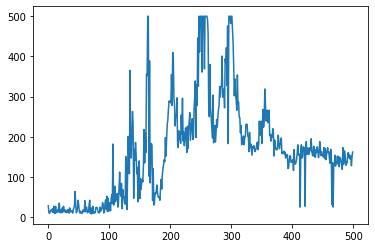

In [12]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)


In [13]:
import numpy as np
np.average(total_reward_episode)

163.186

# Adding Baselines to the already existant REINFORCE Algorithm
\begin{array}
A_t &= G_t - V(s_t) \\
\nabla J(\theta) &= \sum_{t=0}^{T-1} \nabla 
\log \pi(a_t/s_t) \times A_t
\end{array}


In [14]:
import gymnasium as gym
import torch
import torch.nn as nn
from torch.autograd import Variable
env = gym.make('CartPole-v1')